In [1]:
from data_utils import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from feature_utils import *
from functions import *
import json
import random

# Task B: Damage Level Classification

Create a damage level classifier for the `hurricane-matthew` disaster.

## Feature Engineering

Which features are useful for this classification task? Construct them here.

We have around 5000 points with a label one, and we have 1500 points with a label of two. There are two ways we can work with this knowledge. First, we can built a dataset where we have the same number of datapoints for each label. Then, we can try weighing the inputs by their length to make a less-occuring label have a higher impact on the direction of the model.

1    5236
0    2631
3    1740
2 1544nt64

### DataSet1: Same Number of Datapoints per Label

In [2]:
# smallest number of images for a given label is 1544

hurricane_features = pd.read_csv("hurricane_equal_labels.csv")

,Sobel_Edges,LBP,Red_Log,Green_Log,Gabor,Label
count,6176.000000,6176.000000,6176.000000,6176.000000,6176.000000,6176.000000
mean,0.885763,16.916395,7.241595,7.523252,6.458311,1.500000
std,0.498158,1.271751,0.555298,0.525819,3.643570,1.118125
min,0.033381,9.833333,4.485958,4.716797,0.344656,0.000000
25%,0.525074,15.979694,6.881235,7.190165,4.000047,0.750000
50%,0.789928,16.922966,7.226459,7.509186,5.537527,1.500000
75%,1.144976,17.951635,7.609574,7.858637,7.888315,2.250000
max,4.856648,21.339560,9.093276,9.218051,31.501951,3.000000


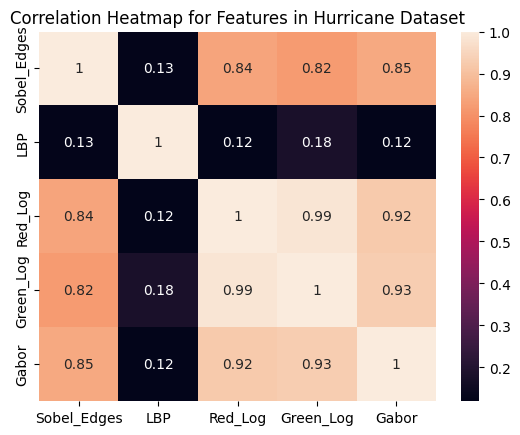

In [3]:
# Correlation heatmap for all features

features_only = hurricane_features.drop(columns = ["Label"])
heatmap = sns.heatmap(features_only.corr(), annot = True)
heatmap.set_title("Correlation Heatmap for Features in Hurricane Dataset")

hurricane_features.describe()

## Model Training

Decide on an appropriate model and train it here. It may be necessary to compare between different types of models, and also tune hyperparameters later.

Use the same models used above by Marei and Sophia to compare performance, then see if it is possible to improve the network architecture for the CNN, or if we need to prepare our data differently for this dataset

In [3]:
# function definitions and imports for this section
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# functions 

def calculate_correlations(data, target='Label'):
    correlations = {}
    for column in data.columns:
        if column != target and pd.api.types.is_numeric_dtype(data[column]):
            correlation = data[[column, target]].corr().iloc[0, 1]
            correlations[column] = correlation
    correlation_df = pd.DataFrame.from_dict(correlations, orient='index', columns=['Correlation with Label'])
    
    print(correlation_df.sort_values(by='Correlation with Label', ascending=False))
    
    return correlation_df

def rmse(predicted, actual):
    """
    Calculates RMSE from actual and predicted values.
    """
    return np.sqrt(mean_squared_error(actual, predicted))  


In [5]:
X = hurricane_features.drop('Label', axis=1)
y = hurricane_features['Label']

#Scaling and Normalizing the data so that all feature data is between 0 and 1

scaler = MinMaxScaler(feature_range = (0,1))
sn_X = scaler.fit_transform(X)
sn_X = pd.DataFrame(sn_X, columns=X.columns, index=X.index)

sn_X.describe()

,Sobel_Edges,LBP,Red_Log,Green_Log,Gabor
count,6176.000000,6176.000000,6176.000000,6176.000000,6176.000000
mean,0.176723,0.615585,0.598100,0.623483,0.196219
std,0.103282,0.110527,0.120525,0.116816,0.116941
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.101942,0.534177,0.519885,0.549484,0.117321
50%,0.156854,0.616156,0.594815,0.620358,0.166666
75%,0.230465,0.705557,0.677968,0.697992,0.242115
max,1.000000,1.000000,1.000000,1.000000,1.000000


In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(sn_X, y,test_size=0.20, random_state=42, stratify=y)

columns_list = hurricane_features.columns.tolist()
correlation_df = calculate_correlations(hurricane_features[columns_list])

model = LogisticRegression()
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_valid)

train_rmse = rmse(y_train_pred, y_train)
test_rmse = rmse(y_valid_pred, y_valid)

print(f"Training RMSE: {train_rmse:.2f}")
print(f"Validation RMSE: {test_rmse:.2f}")

             Correlation with Label
LBP                        0.211722
Sobel_Edges               -0.023570
Red_Log                   -0.139005
Green_Log                 -0.159259
Gabor                     -0.167817
Training RMSE: 1.25
Validation RMSE: 1.29


When running the above model, I got an error saying that convergence failed and the total number of iterations was reached. This means that, from iteration to iteration, our error is greater than some built-in tolerance. While the score we receoved was good, I am doubtful that the model is truly converging onto some prediction criteria.

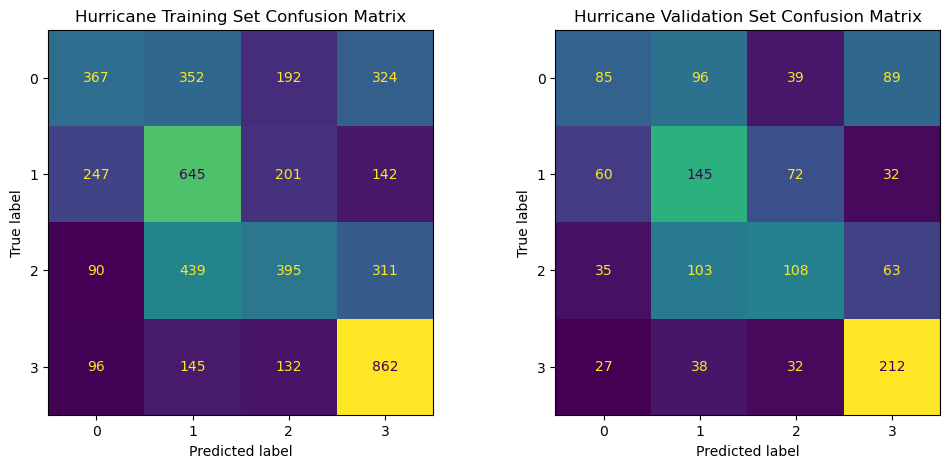

In [8]:
train_cm = confusion_matrix(y_train, y_train_pred)
test_cm = confusion_matrix(y_valid, y_valid_pred)
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ConfusionMatrixDisplay(train_cm, display_labels=[0, 1, 2, 3]).plot(ax=ax[0], colorbar=False)
ax[0].set_title("Hurricane Training Set Confusion Matrix")
ConfusionMatrixDisplay(test_cm, display_labels=[0, 1, 2 ,3]).plot(ax=ax[1], colorbar=False)
ax[1].set_title("Hurricane Validation Set Confusion Matrix")

plt.show()

From these confusion matrices, we see that we are classifying images as label 1 even when the image is not label 1

### Hurricane Logistic with Gradient Descent and PCA

In [9]:
# necessary imports and functions for this section
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

#Logistic Regression
def gradient_descent_logistic(X, y, learning_rate=1, reg=0.001, iterations=1000):
    m, n = X.shape
    weights = np.zeros(n)
    bias = 0
    for i in range(iterations):
        linear_model = np.dot(X, weights) + bias
        y_pred = sigmoid(linear_model)
        dw = (1 / m) * np.dot(X.T, (y_pred - y)) + (reg / m) * weights 
        db = (1 / m) * np.sum(y_pred - y)
        weights -= learning_rate * dw
        bias -= learning_rate * db
    return weights, bias


# PCA for Dimensionality Reduction
def apply_pca(X_train, X_test, n_components=5):
    pca = PCA(n_components=n_components)
    X_train = pca.fit_transform(X_train)
    X_test = pca.transform(X_test)
    print("Explained variance by PCA components:", pca.explained_variance_ratio_)
    return X_train, X_test, pca.explained_variance_ratio_, pca


def predict(X, weights, bias):
    linear_model = np.dot(X, weights) + bias
    y_pred = sigmoid(linear_model)
    return [1 if i > 0.5 else 0 for i in y_pred]

In [10]:
learning = [0.01, 0.05, 0.1, 0.2, 1]
regs = [0.001, 0.01, 0.1, 1, 10]

top_accuracy = 0
params = {}

# Looping over hyperparameters
for rates in learning:
    for reg in regs:
        weights, bias = gradient_descent_logistic(X_train, y_train, rates, reg)
            
        y_pred_ht = predict(X_valid, weights, bias)
            
        accuracy = accuracy_score(y_valid, y_pred_ht)
                
        if accuracy > top_accuracy:
            top_accuracy = accuracy
            params = {'learning_rate': rates, 'regularization': reg}

print(f"Tuned Parameters: {params}")
print(f"Accuracy: {top_accuracy:.4f}")

Tuned Parameters: {'learning_rate': 0.01, 'regularization': 0.001}
Accuracy: 0.2500


In [11]:
#Performing PCA on training and validation set 

if X_train.shape[1] > 4:  
    X_train_pca, X_valid_pca, pca_ratio, pca_hur = apply_pca(X_train, X_valid, n_components=4)


X_train.head()

Explained variance by PCA components: [0.7543195  0.18518361 0.04018158 0.01798968]


,Sobel_Edges,LBP,Red_Log,Green_Log,Gabor
1611,0.286887,0.394603,0.686655,0.681363,0.230058
4338,0.101251,0.374016,0.403537,0.397381,0.055363
754,0.047592,0.375246,0.436062,0.484750,0.083302
2483,0.186113,0.772156,0.727145,0.747521,0.303511
4665,0.051095,0.509586,0.391428,0.393486,0.054114


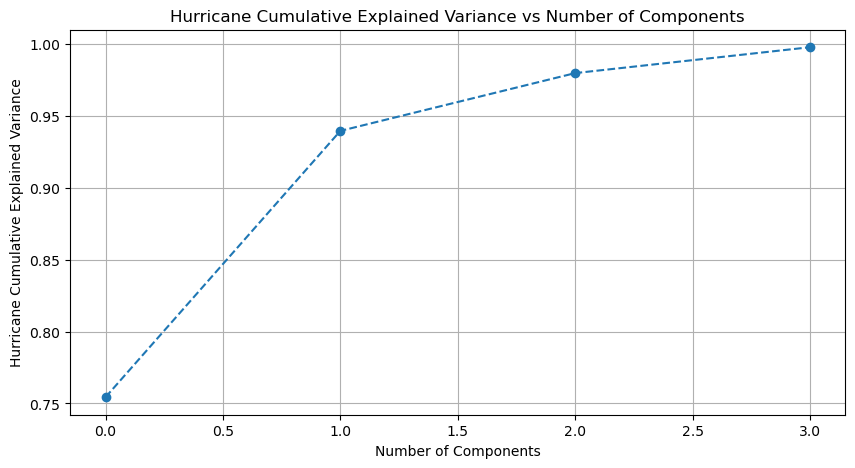

Number of components for 95% variance: 1


In [12]:
#Plotting the cumulative variance

#Calculating cumulative variance 
cumulative_explained_variance = np.cumsum(pca_ratio)

# Plot cumulative explained variance to see effect of each feature on variance
plt.figure(figsize=(10, 5))
plt.plot(cumulative_explained_variance, marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Hurricane Cumulative Explained Variance')
plt.title('Hurricane Cumulative Explained Variance vs Number of Components')
plt.grid(True)
plt.show()

n_components = np.argmax(cumulative_explained_variance >= 95) + 1
print(f"Number of components for 95% variance: {n_components}")

Training RMSE: 1.22
Training Accuracy score: 0.25
Validation RMSE: 1.22
Validation Accuracy score: 0.25


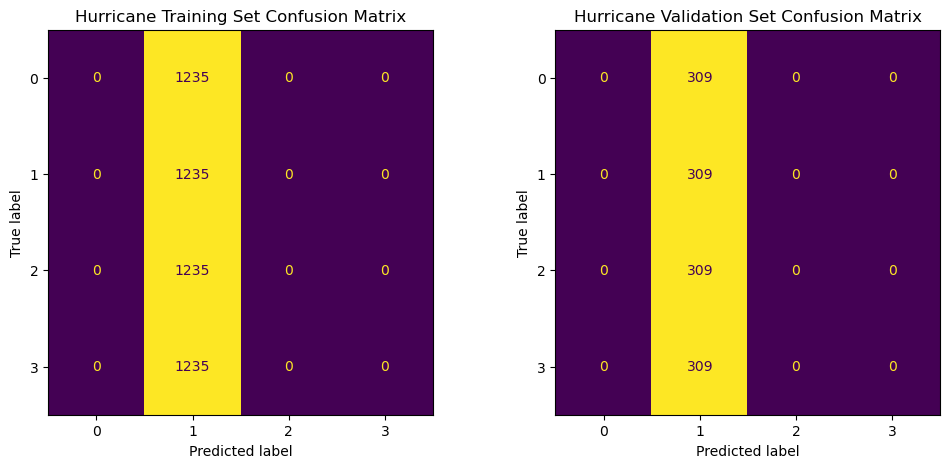

In [13]:
# Modify this line to change learning rate and iterations
weights, bias = gradient_descent_logistic(X_train_pca, y_train.values, learning_rate=1, reg=0.001, iterations=100000)
y_train_pred = predict(X_train_pca, weights, bias)
y_valid_pred = predict(X_valid_pca, weights, bias)

train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
valid_rmse = np.sqrt(mean_squared_error(y_valid, y_valid_pred))
train_accuracy = accuracy_score(y_train, y_train_pred)
valid_accuracy = accuracy_score(y_valid, y_valid_pred)
print(f"Training RMSE: {train_rmse:.2f}")
print(f"Training Accuracy score: {train_accuracy:.2f}")
print(f"Validation RMSE: {valid_rmse:.2f}")
print(f"Validation Accuracy score: {valid_accuracy:.2f}")

train_cm = confusion_matrix(y_train, y_train_pred)
valid_cm = confusion_matrix(y_valid, y_valid_pred)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ConfusionMatrixDisplay(train_cm, display_labels=[0, 1, 2, 3]).plot(ax=ax[0], colorbar=False)
ax[0].set_title("Hurricane Training Set Confusion Matrix")
ConfusionMatrixDisplay(valid_cm, display_labels=[0, 1, 2, 3]).plot(ax=ax[1], colorbar=False)
ax[1].set_title("Hurricane Validation Set Confusion Matrix")
plt.show()

Oh boy, we are not getting fantastic results. We are only getting predictions to be 1; let us try a CNN

### CNN for Hurricane Dataset

In [184]:
# necessary imports and definitions for this section
import torch
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
import torch.nn as nn
from sklearn.metrics import f1_score

#Used this tutorial for help: https://www.digitalocean.com/community/tutorials/writing-cnns-from-scratch-in-pytorch

#Preprocess the images (resize) so they are all the same size (32 x 32)
def toTensor(imageset):
    transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
 
    tensor = [transform(Image.fromarray(image)) for image in imageset]
    return torch.stack(tensor)


# Creating a CNN class
class ConvNeuralNet(nn.Module):

    def __init__(self, num_classes=4): #takes in number of classes, default at 4 for hurricane dataset
        super(ConvNeuralNet, self).__init__()
        #2 layers with a max pooling layer. 3 kernels for RGB data
        self.conv_layer1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(12) 
        self.conv_layer2 = nn.Conv2d(in_channels=12, out_channels=12, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(12)
        self.max_pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.relu1 = nn.ReLU() 
        
        #another 2 layers with a max pooling layer
        self.conv_layer3 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, stride=1, padding=1) # 2 more layers with another max pooling layer
        self.bn3 = nn.BatchNorm2d(24)
        self.conv_layer4 = nn.Conv2d(in_channels=24, out_channels=24, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(24)
        self.max_pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.relu2 = nn.ReLU() 

        #another 2 layers with a max pooling layer
        self.conv_layer5 = nn.Conv2d(in_channels=24, out_channels=24, kernel_size=3, stride=1, padding=1) # 2 more layers with another max pooling layer
        self.bn5 = nn.BatchNorm2d(24)
        self.conv_layer6 = nn.Conv2d(in_channels=24, out_channels=24, kernel_size=3, stride=1, padding=1)
        self.bn6 = nn.BatchNorm2d(24)
        self.max_pool3 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.relu3 = nn.ReLU() 

        #dropout layer to help with overfitting
        self.drop = nn.Dropout2d(p=0.5)
        
        # 32 x 32 tensor images, pooled 2x with kernel size = 2, so they're now 8x8
        # 8 x 8 x 24 (how many we generated)
        self.fc1 = nn.Linear( 4 * 4 * 24, num_classes) #linear layer that maps to the classes
    
    # Moving images through CNN    
    def forward(self, x): 
        out = self.conv_layer1(x) #first conv layer
        out = self.bn1(out) #batch normalization
        out = self.conv_layer2(out) #second conv layer
        out = self.bn2(out) #batch normalization
        out = self.max_pool1(out) #max pooling layer (dimensionality reduction)
        out = self.relu1(out) #relu activation
        
        out = self.conv_layer3(out) #third conv layer
        out = self.bn3(out) #batch normalization
        out = self.conv_layer4(out) #fourth conv layer
        out = self.bn4(out) #batch normalization
        out = self.max_pool2(out) #max pooling layer (dimensionality reduction)
        out = self.relu2(out) #relu activation

        out = self.conv_layer5(out) #third conv layer
        out = self.bn5(out) #batch normalization
        out = self.conv_layer6(out) #fourth conv layer
        out = self.bn6(out) #batch normalization
        out = self.max_pool3(out) #max pooling layer (dimensionality reduction)
        out = self.relu3(out) #relu activation

       
        out = self.drop(out) #dropout layer
        
        out = out.reshape(out.size(0), -1) # flattens to 1D before feeding to linear layers
        
        out = self.fc1(out) # fully connected layer
        return out




In [185]:
# loading in the raw images 

disaster_list = ["hurricane-matthew"]

data = {}
split = "train"

with open('config.json') as config_file:
    config = json.load(config_file)
    # data_dir = "/home/jovyan/shared/course/data100-shared-readwrite/fa24_grad_project_data/satellite-image-data"
    data_dir = "../satellite-image-data"

for disaster in disaster_list:
    print(f"Loading {split} images and labels for {disaster} dataset...")
    images = get_images(data_dir, disaster, split=split)
    labels = get_labels(data_dir, disaster, split=split)
    data[disaster] = {"images": images, "labels": labels}

# choose hurricane-matthew from our labels list 
disaster = disaster_list[0]

#separate the labels and the images for our EDA
hurricane_matthew_labels = data[disaster]["labels"]
hurricane_matthew_images = data[disaster]["images"]

Loading train images and labels for hurricane-matthew dataset...


In [186]:
# data cleaning and formatting for the CNN
random_0_indices = list(np.where(hurricane_matthew_labels == 0)[0])
random_1_indices = list(np.where(hurricane_matthew_labels == 1)[0])
random_3_indices = list(np.where(hurricane_matthew_labels == 3)[0])
random_2_indices = list(np.where(hurricane_matthew_labels == 2)[0])

display(len(random_0_indices)) #2631
display(len(random_1_indices)) #5236
display(len(random_2_indices)) #1544
display(len(random_3_indices)) #1740

# loader objects for PyTorch
images_tensor = toTensor(hurricane_matthew_images)
labels_tensor = torch.tensor(hurricane_matthew_labels, dtype = torch.long)


#Split into validation and training sets
X_train_CNN, X_valid_CNN, y_train_CNN, y_valid_CNN = train_test_split(images_tensor, labels_tensor, test_size=0.2, random_state=42)


#Create tensor datasets to load into the loader object
train_dataset = TensorDataset(X_train_CNN, y_train_CNN)
valid_dataset = TensorDataset(X_valid_CNN, y_valid_CNN)

#Create loader objects (preserves memory by only loading the images batch by batch)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False, num_workers=4)


2631

5236

1544

1740

In [187]:
#finding the proportion of each label

len(hurricane_matthew_labels)
zero = 2631/len(hurricane_matthew_labels)
one = 5236/len(hurricane_matthew_labels)
two = 1544/len(hurricane_matthew_labels)
three = 1740/len(hurricane_matthew_labels)

print(zero)
print(one)
print(two)
print(three)


0.23594296475652407
0.46955430006277465
0.13846291812393507
0.1560398170567662


In [188]:
import torch.optim.lr_scheduler as lr_scheduler

# hyperparameters 
num_classes = 4 #number of classes in our dataset
learning_rate = 0.001 #initializing initial learning rate

# set device to run 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#setting up model using our custom class
cnn_model_11 = ConvNeuralNet(num_classes)

# using cross entropy for the loss function
class_weights = torch.tensor([0.23594296475652407, 0.46955430006277465, 0.13846291812393507, 0.1560398170567662], device=device)
loss_func = nn.CrossEntropyLoss(weight=class_weights)

# set optimizer for CNN (stochastic gradient descent)
optimizer = torch.optim.SGD(cnn_model_11.parameters(), lr=learning_rate, weight_decay = 1e-4, momentum = 0.9)

#takes ~20 mins to run!
num_epochs = 50 #number of times to run the CNN


In [189]:
#Counters for visualization of training loss and accuracy
train_loss = []
train_accuracy = []
train_f1 = []


for epoch in range(num_epochs):
    #training mode
    cnn_model_11.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    true_labels = []
    pred_labels = []

    # user loader object to load the data
    for i, (images, labels) in enumerate(train_loader):  
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward through the CNN
        outputs = cnn_model_11(images) 
        loss = loss_func(outputs, labels) #calculate loss
        
        # Backpropagation, optimize parameters
        optimizer.zero_grad() #use SGD to optimize weights
        loss.backward() #check new gradient with loss function
        optimizer.step() #update weights

        running_loss += loss.item() #add all loss over this loop to running_loss

        _, predicted_train = torch.max(outputs.data, 1) # get current prediction for this epoch
        total_train += labels.size(0)
        correct_train += (predicted_train == labels).sum().item() #compare prediction with label

        true_labels.extend(labels.cpu().numpy()) #adding true labels to a flat list
        pred_labels.extend(predicted_train.cpu().numpy()) #adding pred labels to a flat list
    

    
    # Calculate average loss and accuracy over the epoch
    avg_loss = running_loss / len(train_loader) #gives the average loss over the epoch
    train_loss.append(avg_loss)
    t_accuracy = 100 * correct_train / total_train
    train_accuracy.append(t_accuracy)
    train_f1.append(f1_score(true_labels, pred_labels, average='weighted'))
    
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {train_accuracy[-1]:.2f}%, F1 Score: {train_f1[-1]:.4f}')


Epoch [1/50], Loss: 0.9257, Accuracy: 48.21%, F1 Score: 0.3661
Epoch [2/50], Loss: 0.8516, Accuracy: 50.10%, F1 Score: 0.3846
Epoch [3/50], Loss: 0.8200, Accuracy: 51.10%, F1 Score: 0.4074
Epoch [4/50], Loss: 0.8073, Accuracy: 52.78%, F1 Score: 0.4375
Epoch [5/50], Loss: 0.7907, Accuracy: 54.02%, F1 Score: 0.4577
Epoch [6/50], Loss: 0.7747, Accuracy: 55.82%, F1 Score: 0.4818
Epoch [7/50], Loss: 0.7606, Accuracy: 55.63%, F1 Score: 0.4831
Epoch [8/50], Loss: 0.7591, Accuracy: 56.30%, F1 Score: 0.4895
Epoch [9/50], Loss: 0.7483, Accuracy: 56.43%, F1 Score: 0.4939
Epoch [10/50], Loss: 0.7401, Accuracy: 57.20%, F1 Score: 0.5017
Epoch [11/50], Loss: 0.7366, Accuracy: 57.46%, F1 Score: 0.5049
Epoch [12/50], Loss: 0.7260, Accuracy: 57.81%, F1 Score: 0.5097
Epoch [13/50], Loss: 0.7188, Accuracy: 58.34%, F1 Score: 0.5165
Epoch [14/50], Loss: 0.7136, Accuracy: 58.79%, F1 Score: 0.5232
Epoch [15/50], Loss: 0.7120, Accuracy: 58.76%, F1 Score: 0.5242
Epoch [16/50], Loss: 0.7031, Accuracy: 58.97%, F1

In [190]:
#Running validation set through the optimized CNN to calculate accuracy

cnn_model_11.eval() #model in evaluation mode


#collecting metrics from validation evaluation run as well
valid_running_loss = 0.0
correct_valid = 0
total_valid = 0
true_labels_valid = []
pred_labels_valid = []

#do not need gradient optimization for validation set
with torch.no_grad(): 
    for images, labels in valid_loader: 
        images = images.to(device)
        labels = labels.to(device)
        outputs = cnn_model_11(images)

        #loss
        loss = loss_func(outputs, labels)
        valid_running_loss += loss.item()

        #accuracy
        _, predicted_valid = torch.max(outputs.data, 1)
        total_valid += labels.size(0)
        correct_valid += (predicted_valid == labels).sum().item()

        true_labels_valid.extend(labels.cpu().numpy())
        pred_labels_valid.extend(predicted_valid.cpu().numpy())

avg_valid_loss = valid_running_loss / len(valid_loader)
valid_accuracy =  100 * correct_valid / total_valid
valid_f1 = f1_score(true_labels_valid, pred_labels_valid, average='weighted')
    
print(f'Validation Loss: {avg_valid_loss:.4f}')
print(f'Validation Accuracy: {valid_accuracy:.2f}%')
print(f'Validation F1 Score: {valid_f1:.4f}')

Validation Loss: 0.8671
Validation Accuracy: 56.93%
Validation F1 Score: 0.5090


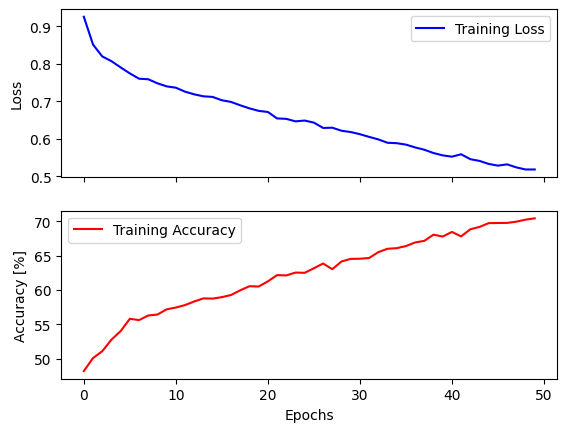

In [191]:
#Visualization of training loss and accuracy

xplot = np.arange(num_epochs)

fig1, ax1 = plt.subplots(2, 1, sharex = True)
ax1[0].plot(xplot, train_loss, 'blue', label="Training Loss")
ax1[0].set_ylabel('Loss')
ax1[0].legend()
ax1[1].plot(xplot, train_accuracy, 'red', label='Training Accuracy')
ax1[1].set_ylabel('Accuracy [%]')
ax1[1].legend()
plt.xlabel('Epochs')
plt.show()

## Performance Assessment

Use the model to generate predictions for the `test_images_hurricane-matthew.npz` images. This should be in a CSV file `test_images_hurricane-matthew_predictions.csv` consisting of a single column with no header, with a 0-3 prediction of the damage level. The prediction in row *i* should correspond to the *i*th image.

In [194]:
test_im_hurricane_path = os.path.join(data_dir, "test_images_hurricane-matthew.npz")
test_im_hurricane = load_images(test_im_hurricane_path)

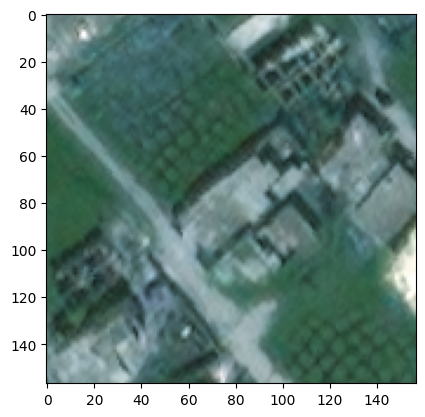

In [22]:
plt.imshow(test_im_hurricane[0]);

In [45]:
test_sobel_edges = img_to_sobel(test_im_hurricane)
test_lbp = img_to_LBP(test_im_hurricane)  
test_red, test_green, test_blue = image_to_RGB(test_im_hurricane)
test_red_log = np.log(np.array(test_red))
test_green_log = np.log(np.array(test_green))
test_blue_log = np.log(np.array(test_blue))  # not used, keeping for consistency
test_gabor = img_to_gabor(test_im_hurricane)

# Combine all features into df
test_features = pd.DataFrame({
    'Sobel_Edges': test_sobel_edges,
    "LBP": test_lbp,
    'Red_Log': test_red_log,
    'Green_Log': test_green_log,
    'Gabor': test_gabor
})

## Logistic

In [46]:
test_predictions = model.predict(test_features)
output_path = "logistic_test_images_hurricane_predictions.csv"
pd.DataFrame(test_predictions).to_csv(output_path, index=False, header=False)

## Gradient

In [47]:
pca_test = pca_hur.transform(test_features)

test_predictions = predict(pca_test, weights, bias)

output_path = "gradient_logistic_test_images_hurricane_predictions.csv"
pd.DataFrame(test_predictions).to_csv(output_path, index=False, header=False)

print(f"Predictions saved to {output_path}")

Predictions saved to gradient_logistic_test_images_hurricane_predictions.csv


/tmp/ipykernel_1544756/896558915.py:6: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


## CNN

In [195]:
# Define a loader for the test dataset
test_images = resize(test_im_hurricane)
test_features = toTensor(test_images)

test_dataset = TensorDataset(test_features)

test_loader =  DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

cnn_model_11.eval() #model in test mode

test_predictions = []

#do not need gradient optimization 
with torch.no_grad(): 
    for images in test_loader: 
        images = images[0].to(device)
        outputs = cnn_model_11(images)

        _, predicted = torch.max(outputs.data, 1)

        test_predictions.extend(predicted.cpu().numpy())

output_path = "cnn_test_images_hurricane-matthew_predictions_v2.csv"
predictions_df = pd.DataFrame(test_predictions, columns=["pred"])
predictions_df.to_csv(output_path, index=False)

print(f"Predictions saved to {output_path}")

Predictions saved to cnn_test_images_hurricane-matthew_predictions_v2.csv
